In [3]:
import pandas as pd
import numpy as np
import pickle
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from src.data.common import data_train, data_validation, data_test

In [6]:
with open('data/interim/hydrated/200316_text_processed.pkl', 'rb') as input_file:
    Corona = pickle.load(input_file)

with open('data/interim/hydrated/trump_text_processed.pkl', 'rb') as input_file:
    Trump = pickle.load(input_file)

no_Trump = len(Trump['text_processed'].values)

# Corona train
Corona_train = list(Corona.loc[Corona.index.intersection(data_train.index)]['text_processed'].values) + list(Corona.loc[Corona.index.intersection(data_validation.index)]['text_processed'])

# Corona val
Corona_test = list(Corona.loc[Corona.index.intersection(data_test.index)]['text_processed'].values)

In [5]:
Vector = TfidfVectorizer()
Vector.fit(Corona_train)
Corona_train_tfidf = Vector.transform(Corona_train)
Corona_test_tfidf = Vector.transform(Corona_test)
Trump_tfidf = Vector.transform(Trump['text_processed'].values)

In [6]:
lda = LatentDirichletAllocation(n_components=5, n_jobs = -1, verbose = 1)
lda.fit(Corona_train_tfidf)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(n_components=5, n_jobs=3, verbose=1)

In [16]:
Corona_likelihoods = []
for tweet in tqdm(Corona_test_tfidf, total = len(Corona_test)):
    Corona_likelihoods.append(lda.score(tweet))

100%|██████████| 8830/8830 [25:00<00:00,  5.88it/s]


In [17]:
Trump_likelihoods = []
for tweet in tqdm(Trump_tfidf, total = no_Trump):
    Trump_likelihoods.append(lda.score(tweet))

100%|██████████| 8830/8830 [23:59<00:00,  6.13it/s]


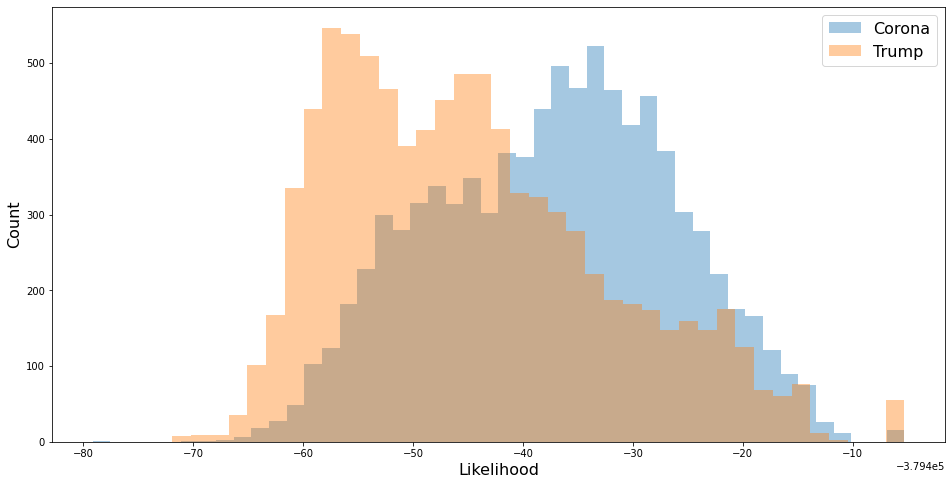

In [45]:
fig, ax = plt.subplots(figsize = (16,8))
for likelihood, label in zip([Corona_likelihoods, Trump_likelihoods], [f'Corona', 'Trump']):
    sns.distplot(likelihood,  ax=ax, kde=False, label = label + f': {len(likelihood)} tweets' )

plt.legend(fontsize = 14)
plt.xlabel('Likelihood', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.show()